In [ ]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

from scipy.stats import kruskal, f_oneway
from statsmodels.stats.multitest import multipletests
from scipy.cluster import hierarchy

from one.api import ONE

from reproducible_ephys_functions import figure_style, LAB_MAP

import os
import numpy as np
from tqdm import tqdm
from pathlib import Path
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader

region_cols = figure_style(return_colors=True)
_, b, lab_cols = LAB_MAP()

ONE.setup(
    base_url="https://openalyx.internationalbrainlab.org", silent=True,
    cache_dir="/burg/stats/users/yz4123/Downloads"
)
one = ONE(password='international')

In [ ]:
varis = ['choice', 'stimside', 'reward', 'wheel-speed']
re_regions = ["PO", "LP", "DG", "CA1", "VISa"]

dec_d = {'stimside': 'stimside', 'choice': 'choice',
        'feedback': 'feedback', 'wheel-speed': 'wheel-speed'}     

In [65]:
filter_out_eids = []
df_per_var = []

for var in varis:
    df_list = []
    for fold_idx in range(1, 5+1):
        res_path = Path(f"/burg/stats/users/yz4123/Downloads/results/")
        configs = np.load(res_path/var/"multi-region-reduced_rank"/f"fold_{fold_idx}"/"configs.npy", allow_pickle=True)
        res_dict = {}
        for region in re_regions:
            res_dict[region] = {}
            path = res_path/var/"multi-region-reduced_rank"/f"fold_{fold_idx}"/region
            for fname in os.listdir(path):
                if os.path.isdir(path/fname):
                    continue
                eid = fname[:-4]
                tmp = np.load(path/fname, allow_pickle=True).item()["test_metric"]
                if var in ["choice", "stimside", "reward"]:
                    tmp_chance_lvl = np.load(path/fname, allow_pickle=True).item()["test_chance_metric"]
                    tmp = tmp - tmp_chance_lvl
                res_dict[region][eid] = tmp

        df = pd.DataFrame(res_dict).reset_index()
        df_melted = pd.melt(df, id_vars=['index'], var_name='region', value_name='score')
        df_melted.columns = ["eid", "region", "score"]

        df_melted["unitcount"] = None
        for config in configs:
            mask = (df_melted["eid"] == config["eid"]) & (df_melted["region"] == config["region"])
            row_idx = df_melted[mask].index.item()
            df_melted.loc[row_idx, "unitcount"] = config["n_units"]
        df_list.append(df_melted)

    merged_df = pd.concat(df_list)
    df = merged_df.groupby(["eid", "region"]).agg({"score": 'mean', "unitcount": "first"}).reset_index()
    filter_out_eids += list(df.loc[df["score"] < -0.05, "eid"])
    df_per_var.append(df)

filter_out_eids = list(set(filter_out_eids))

for i, var in enumerate(varis):
    df = df_per_var[i]
    for _eid in filter_out_eids:
        df.drop(df[df["eid"] == _eid].index, inplace=True)
    df.to_parquet(f"{var}.parquet", engine="pyarrow")

In [137]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score

def evaluate_f1_with_permutation(unit, varis, index, b, one, n_permutations=5000, random_state=42):
    """
    Evaluate F1 score with permutation testing.
    
    Parameters:
        varis (list): A list of variable names.
        index (int): Index to select the variable from `varis`.
        b (dict): A mapping to decode lab information from paths.
        one (object): An object with method `eid2path` to retrieve paths based on `eid`.
        n_permutations (int): Number of permutations for the test.
        random_state (int): Seed for controlling random number generation (default is 42).
    
    Returns:
        dict: Observed F1 score and p-value from the permutation test.
    """
    # Load and preprocess the data
    vari = varis[index]
    print(f"Processing variable: {vari}")
    data_file = f'{vari}.parquet'
    d = pd.read_parquet(data_file)
    
    # Add 'lab' and 'subject' columns based on paths
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]
    
    # Drop rows with missing values in specified columns
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])
    
    # Prepare feature matrix X and target vector y
    X = np.c_[d.score.to_numpy(), d.unitcount.to_numpy()]
    if unit == "region":
        y = d.region.to_numpy()
    elif unit == "lab":
        y = d.lab.to_numpy()

    print(f"Compare {unit} for variable {vari}:")
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Compute F1 score for the original data
    f1_cv = []
    for train_idx, test_idx in skf.split(X, y):
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        f1 = f1_score(y[test_idx], pred, average='macro')
        f1_cv.append(f1)
    
    observed_f1 = np.mean(f1_cv)
    print(f"Observed F1 score: {observed_f1}")
    
    # Permutation test
    f1_permuted = []
    np.random.seed(random_state)  # Set seed for reproducibility of permutations
    for _ in range(n_permutations):
        # Permute the labels
        y_permuted = np.random.permutation(y)
        
        # Recompute F1 score with permuted labels
        f1_cv_perm = []
        for train_idx, test_idx in skf.split(X, y_permuted):
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X[train_idx], y_permuted[train_idx])
            pred = clf.predict(X[test_idx])
            f1 = f1_score(y_permuted[test_idx], pred, average='macro')
            f1_cv_perm.append(f1)
        
        f1_permuted.append(np.mean(f1_cv_perm))
    
    # Calculate p-value
    p_value = np.mean(np.array(f1_permuted) >= observed_f1)
    print(f"Permutation test p-value: {p_value}")
    
    return observed_f1, p_value

In [138]:
for unit in ["region", "lab"]:
    for vari_idx, vari in enumerate(varis):
        if unit == "region":
            region_f1_dict[vari], region_pval_dict[vari] = evaluate_f1_with_permutation(
                unit, varis, vari_idx, b, one, n_permutations=5000
            )
        elif unit == "lab":
            lab_f1_dict[vari], lab_pval_dict[vari] = evaluate_f1_with_permutation(
                unit, varis, vari_idx, b, one, n_permutations=5000
            )

Processing variable: choice
Compare region for variable choice:
Observed F1 score: 0.2136260564191645
Permutation test p-value: 0.0204
Processing variable: stimside
Compare region for variable stimside:
Observed F1 score: 0.2776710639314594
Permutation test p-value: 0.0
Processing variable: reward
Compare region for variable reward:
Observed F1 score: 0.2526691338408259
Permutation test p-value: 0.001
Processing variable: wheel-speed
Compare region for variable wheel-speed:
Observed F1 score: 0.25357350348608926
Permutation test p-value: 0.0012
Processing variable: choice
Compare lab for variable choice:
Observed F1 score: 0.03799503305918401


/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_s

Permutation test p-value: 0.8272
Processing variable: stimside
Compare lab for variable stimside:
Observed F1 score: 0.05624979010727053


/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_s

Permutation test p-value: 0.178
Processing variable: reward
Compare lab for variable reward:
Observed F1 score: 0.04289018738075342


/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_s

Permutation test p-value: 0.549
Processing variable: wheel-speed
Compare lab for variable wheel-speed:
Observed F1 score: 0.04704620745082032


/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_s

Permutation test p-value: 0.3962


/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/burg/home/yz4123/.conda/envs/ibl_repro_ephys/lib/python3.9/site-packages/sklearn/model_selection/_s

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

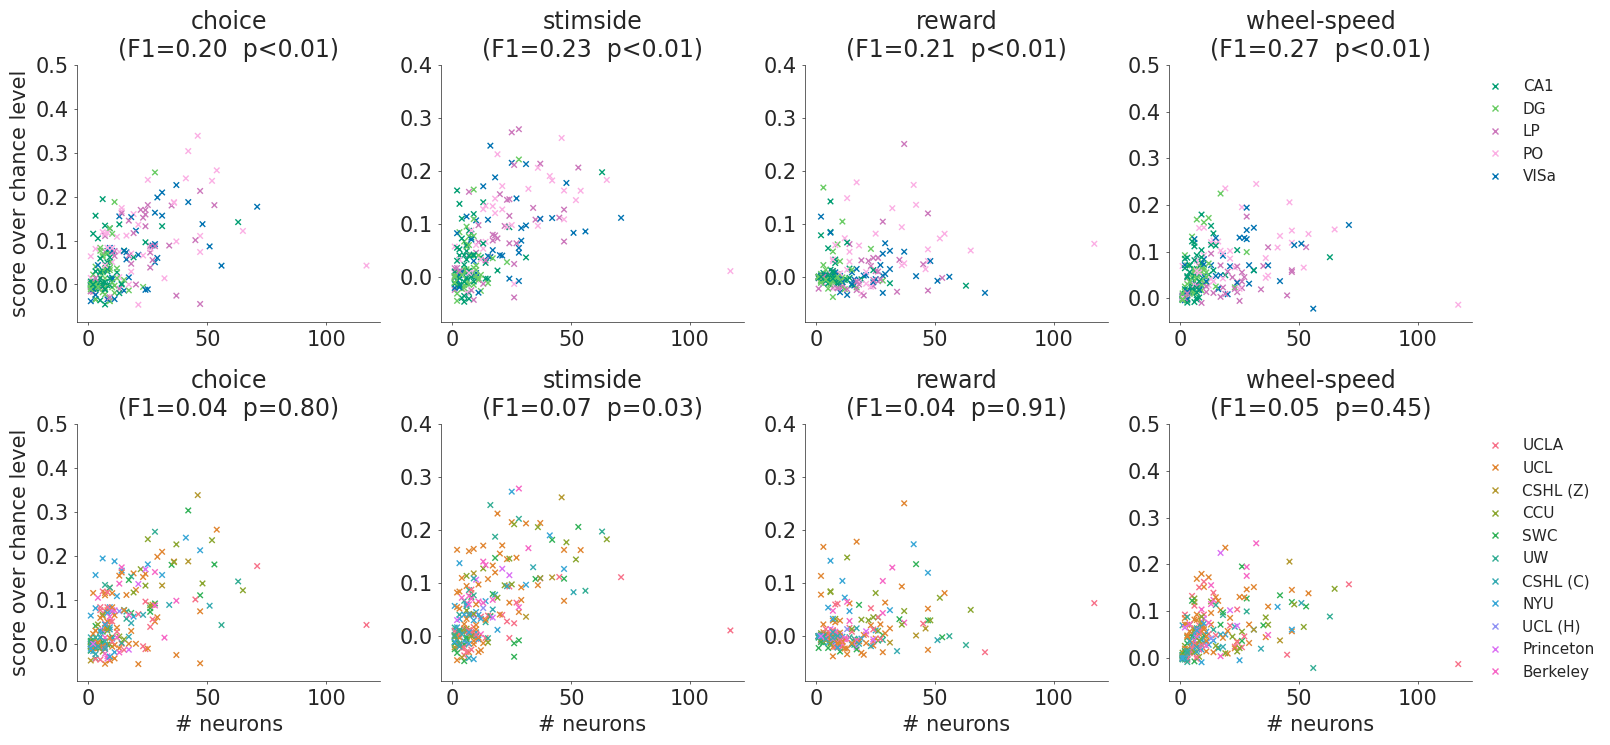

In [86]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

palette = [region_cols["CA1"], region_cols["DG"], region_cols["LP"], region_cols["PO"], region_cols["PPC"]]

fig, axes = plt.subplots(2, len(varis), figsize=(18, 8))

for i, vari in enumerate(varis):
    data_file = f'{vari}.parquet'
    d = pd.read_parquet(data_file)
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])
    sns.scatterplot(
        data=d, x="unitcount", y="score", hue="region", #size=15,
        ax=axes[0,i], marker='x', linewidth=1, palette=palette,
    )
    axes[0,i].set_xlabel("", fontsize=20)
    if i == 0:
        axes[0,i].set_ylabel("score over chance level", fontsize=15)
        axes[0,i].legend(
            loc="upper right", bbox_to_anchor=(4.925, 1.), fontsize=11, ncol=1, frameon=False
        )
    else:
        axes[0,i].set_ylabel("", fontsize=20)
        axes[0,i].legend().set_visible(False)
    axes[0,i].set_title(f"{vari}\n(F1={region_f1_dict[vari]:.2f}  p<0.01)", fontsize=17)
    axes[0,i].tick_params(labelsize=15)

    sns.scatterplot(
        data=d, x="unitcount", y="score", hue="lab", #size=15,
        ax=axes[1,i], marker='x', linewidth=1, #palette=palette,
    )
    axes[1,i].set_xlabel("# neurons", fontsize=15)
    if i == 0:
        axes[1,i].set_ylabel("score over chance level", fontsize=15)
        axes[1,i].legend(
            loc="upper right", bbox_to_anchor=(5.05, 1.), fontsize=11, ncol=1, frameon=False
        )
    else:
        axes[1,i].set_ylabel("", fontsize=20)
        axes[1,i].legend().set_visible(False)
    axes[1,i].set_title(f"{vari}\n(F1={lab_f1_dict[vari]:.2f}  p={lab_pval_dict[vari]:.2f})", fontsize=17)
    axes[1,i].tick_params(labelsize=15)

    if i == 0:
        axes[0,i].set_ylim(-0.085, 0.5)
        axes[1,i].set_ylim(-0.085, 0.5)
    elif i == 1:
        axes[0,i].set_ylim(-0.085, 0.4)
        axes[1,i].set_ylim(-0.085, 0.4)
    elif i == 2:
        axes[0,i].set_ylim(-0.085, 0.4)
        axes[1,i].set_ylim(-0.085, 0.4)
    else:
        axes[0,i].set_ylim(-0.05, 0.5)
        axes[1,i].set_ylim(-0.05, 0.5)

fig.subplots_adjust(hspace=0.4)

plt.tight_layout()
# plt.savefig("decode_scores_by_num_units.png", dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

choice_VISa: p-value = 1.000
choice_CA1: p-value = 1.000
choice_DG: p-value = 1.000
choice_LP: p-value = 1.000
choice_PO: p-value = 1.000
stimside_VISa: p-value = 1.000
stimside_CA1: p-value = 1.000
stimside_DG: p-value = 1.000
stimside_LP: p-value = 1.000
stimside_PO: p-value = 0.776
reward_VISa: p-value = 1.000
reward_CA1: p-value = 1.000
reward_DG: p-value = 1.000
reward_LP: p-value = 1.000
reward_PO: p-value = 1.000
wheel-speed_VISa: p-value = 1.000
wheel-speed_CA1: p-value = 1.000
wheel-speed_DG: p-value = 1.000
wheel-speed_LP: p-value = 1.000
wheel-speed_PO: p-value = 1.000


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

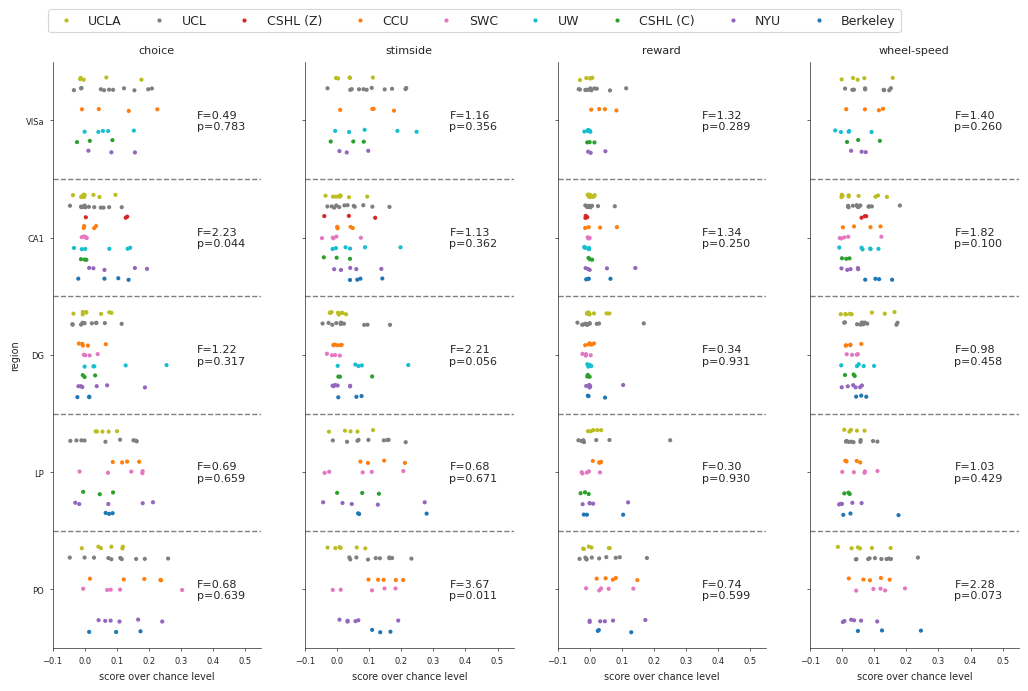

In [87]:
nscores=3
tt='stripplot'
sb='lab'

regs = ['VISa', 'CA1', 'DG', 'LP', 'PO']

# Use loaded data paths as in `pool_results_across_analyses`
# _, pa = get_allen_info()

# Pooled data paths
ana = 'dec'

ps = {}
fig, axs = plt.subplots(nrows=1, ncols=len(varis), sharex=True, sharey=True, figsize=(10.88, 7.03))
k = 0

for vari in varis:
    # Load pooled data based on `pool_results_across_analyses`

    data_file = f'{vari}.parquet'
    d = pd.read_parquet(data_file)
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])

    # Plot logic
    if tt == 'mean_std':
        reg_stats = d.groupby('region')['score'].agg(
            mean_score=np.nanmean, std_score=np.nanstd, count_scores='count'
        ).reset_index()
        reg_stats = reg_stats[reg_stats['count_scores'] >= nscores]

        x = reg_stats['mean_score'].values
        y = reg_stats['std_score'].values
        regions = reg_stats['region'].values
        cols = [pa[region] for region in regions]
        sizes = reg_stats['count_scores'].values

        axs[k].scatter(x, y, color=cols, s=sizes if ana == 'dec' else sizes / 10)
        for i, reg in enumerate(regions):
            axs[k].annotate(f'  {reg}', (x[i], y[i]), fontsize=5, color=cols[i])

        axs[k].set_title(vari)
        axs[k].set_xlabel('mean')
        axs[k].set_ylabel('std')

    elif tt == 'stripplot':
        filtered_data = d[d['region'].isin(regs)]
        labs_counts = filtered_data.groupby([sb, 'region'])['score'].count().reset_index(name='score_count')
        valid_labs_regions = labs_counts[labs_counts['score_count'] >= nscores]
        filtered_data = pd.merge(filtered_data, valid_labs_regions[[sb, 'region']], on=[sb, 'region'])

        labss = np.unique(filtered_data[sb].values)
        palette = {lab: lab_cols[lab] for lab in labss} if sb == 'lab' else None

        sns.stripplot(x='score', y='region', hue=sb, palette=palette, data=filtered_data, jitter=True if sb == 'lab' else False, dodge=True, ax=axs[k], order=regs, size=3)
        for i, region in enumerate(regs):
            if i == len(regs) - 1:
                continue
            axs[k].axhline(i + 0.5, color='grey', linestyle='--')

        axs[k].set_title(vari)
        if sb == 'lab':
            if k != 0:
                axs[k].legend([], [], frameon=False)
            else:
                axs[k].legend(loc='lower left', fontsize=9, bbox_to_anchor=(-0.05, 1.04), ncols=len(labss)).set_draggable(True)

        # ANOVA
        labs = np.unique(d[sb].values)
        for reg in regs:
            scores_by_lab = [d[(d[sb] == lab) & (d['region'] == reg)]['score'].values for lab in labs]
            filtered_scores_by_lab = [lab_scores for lab_scores in scores_by_lab if lab_scores.size >= nscores]

            if len(filtered_scores_by_lab) < 2:
                continue

            # F, p = kruskal(*filtered_scores_by_lab)
            F, p = f_oneway(*filtered_scores_by_lab)
            ps[f"{vari}_{reg}"] = p
            m = np.max(np.concatenate(scores_by_lab))

            weight = 'bold' if p < 0.05/len(labs) else 'normal'
            if vari == 'wheel-speed':
                x = 0.35
            elif vari == 'stimside':
                x = 0.35
            elif vari == 'whisker-motion-energy':
                x = 0.5
            else:
                x = 0.35
            axs[k].text(x, regs.index(reg), f'F={F:.2f}\np={p:.3f}', weight=weight, ha='left', va='center', fontsize=8)
            axs[k].set_xlim(-0.1, 0.55)
            axs[k].set_xlabel("score over chance level")
            # axs[k].axvline(x=0., color='grey', linestyle='--', linewidth=1.)
    k += 1

if tt == 'stripplot':
    p_values_list = list(ps.values())
    _, ps_corrected, _, _ = multipletests(p_values_list, alpha=0.05, method='fdr_by')
    corrected_p_values_dict = dict(zip(ps.keys(), ps_corrected))
    for key, value in corrected_p_values_dict.items():
        print(f"{key}: p-value = {value:.3f}")

fig.subplots_adjust(top=0.922, bottom=0.088, left=0.094, right=0.982, hspace=0.2, wspace=0.211)

# plt.savefig("decode_scores_by_lab_region.png", dpi=300)

plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

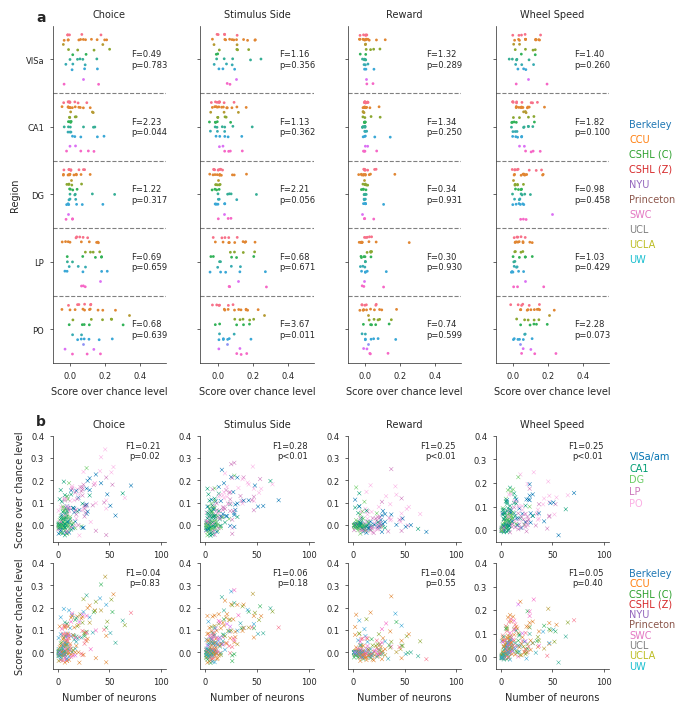

In [165]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from reproducible_ephys_functions import (
    figure_style, get_row_coord, get_label_pos, plot_vertical_institute_legend,
    BRAIN_REGIONS, REGION_RENAME
)
import figrid as fg
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

# Styles and region colors
region_colors = figure_style(return_colors=True)

# Define figure layout
width = 7
height = 7.3
fig = plt.figure(figsize=(width, height))

xspans = get_row_coord(width, [10, 1], hspace=0.2)
yspans = get_row_coord(height, [3, 2], hspace=0.8, pad=0.1)

axs = {
    'A': fg.place_axes_on_grid(fig, xspan=xspans[0], yspan=yspans[0], dim=[1, 4], wspace=0.3),
    'B': fg.place_axes_on_grid(fig, xspan=xspans[0], yspan=yspans[1], dim=[2, 4], wspace=0.3),
    'labs_a': fg.place_axes_on_grid(fig, xspan=xspans[1], yspan=yspans[0]),
    'regs_labs_b': fg.place_axes_on_grid(fig, xspan=xspans[1], yspan=yspans[1]),
}

# Add figure labels
labels = [
    {'label_text': 'a', 'xpos': get_label_pos(width, xspans[0][0]),
     'ypos': get_label_pos(height, yspans[0][0], pad=0.1),
     'fontsize': 10, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    {'label_text': 'b', 'xpos': get_label_pos(width, xspans[0][0]),
     'ypos': get_label_pos(height-2.5, yspans[1][0], pad=0.1), 'fontsize': 10,
     'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
]
fg.add_labels(fig, labels)

# Plot institutions and regions
axs['labs_a'].set_axis_off()
institutions = ['Berkeley', 'CCU', 'CSHL (C)', 'CSHL (Z)', 'NYU', 'Princeton', 'SWC', 'UCL',
                'UCLA', 'UW']
plot_vertical_institute_legend(institutions, axs['labs_a'], span=(0.3, 0.7), offset=0)

axs['regs_labs_b'].set_axis_off()
pos = np.linspace(0.7, 0.9, len(BRAIN_REGIONS))[::-1]
for p, reg in zip(pos, BRAIN_REGIONS):
    axs['regs_labs_b'].text(0, p, REGION_RENAME[reg], color=region_colors[reg], fontsize=7, transform=axs['regs_labs_b'].transAxes)
plot_vertical_institute_legend(institutions, axs['regs_labs_b'], span=(0, 0.4), offset=0)

# Adjust figure layout
adjust = 0.3
fig.subplots_adjust(top=1 - adjust / height, bottom=(adjust + 0.2) / height, left=(adjust + 0.2) / width,
                     right=1 - (adjust - 0.2) / width)


# Panel A function with added grey dashed lines
def plot_panel_a(ax, varis, regs, tt, sb, nscores):
    variable_titles = ["Choice", "Stimulus Side", "Reward", "Wheel Speed"]
    for k, vari in enumerate(varis):
        data_file = f'{vari}.parquet'
        d = pd.read_parquet(data_file)
        # Process data
        pths = one.eid2path(d['eid'].values)
        d['lab'] = [b[str(p).split('/')[6]] for p in pths]
        d['subject'] = [str(p).split('/')[8] for p in pths]
        d = d.dropna(subset=['score', 'lab', 'region', 'subject'])

        if tt == 'stripplot':
            # Filter data
            filtered_data = d[d['region'].isin(regs)]
            
            sns.stripplot(
                x='score', y='region', hue=sb, data=filtered_data, jitter=True, dodge=True,
                ax=ax[k], order=regs, size=2
            )
            
            # Add grey dashed lines between regions
            for i in range(len(regs) - 1):
                ax[k].axhline(i + 0.5, color='grey', linestyle='--', linewidth=0.8)
            
            # Configure titles and labels
            ax[k].set_title(vari.capitalize())
            ax[k].set_xlabel("Score over chance level")

            # ANOVA analysis for stripplot
            labs = np.unique(d[sb].values)
            for reg in regs:
                scores_by_lab = [d[(d[sb] == lab) & (d['region'] == reg)]['score'].values for lab in labs]
                filtered_scores_by_lab = [lab_scores for lab_scores in scores_by_lab if lab_scores.size >= nscores]

                if len(filtered_scores_by_lab) < 2:
                    continue

                F, p = f_oneway(*filtered_scores_by_lab)
                ps[f"{vari}_{reg}"] = p
                m = np.max(np.concatenate(scores_by_lab))

                weight = 'bold' if p < 0.05 / len(labs) else 'normal'
                if vari == 'wheel-speed':
                    x = 0.35
                elif vari == 'stimside':
                    x = 0.35
                elif vari == 'whisker-motion-energy':
                    x = 0.5
                else:
                    x = 0.35
                
                # Add ANOVA results (F and p values) to the plot
                ax[k].set_xlim(-0.1, 0.55)
                ax[k].text(x, regs.index(reg), f'F={F:.2f}\np={p:.3f}', weight=weight, ha='left', va='center', fontsize=6)

                if k in [1, 2, 3]:
                    ax[k].set_yticklabels("")


        elif tt == 'mean_std':
            reg_stats = d.groupby('region')['score'].agg(
                mean_score=np.nanmean, std_score=np.nanstd, count_scores='count'
            ).reset_index()
            x = reg_stats['mean_score'].values
            y = reg_stats['std_score'].values
            ax[k].scatter(x, y, s=10, label=vari)
        ax[k].legend().set_visible(False)

        # Add variable title only for the first row
        if k < len(varis):
            ax[k].set_title(variable_titles[k], fontsize=7)

        if k == 0:
            ax[k].set_ylabel("Region")
        else:
            ax[k].set_ylabel("")


# Panel B function with updated variable titles
def plot_panel_b(ax, varis, region_f1_dict, lab_f1_dict, lab_pval_dict, region_cols):
    palette = [region_cols["CA1"], region_cols["DG"], region_cols["LP"], region_cols["PO"], region_cols["PPC"]]

    # Updated variable titles
    variable_titles = ["Choice", "Stimulus Side", "Reward", "Wheel Speed"]
    for i, vari in enumerate(varis):
        data_file = f'{vari}.parquet'
        d = pd.read_parquet(data_file)
        # Process data
        pths = one.eid2path(d['eid'].values)
        d['lab'] = [b[str(p).split('/')[6]] for p in pths]
        d['subject'] = [str(p).split('/')[8] for p in pths]
        d = d.dropna(subset=['score', 'lab', 'region', 'subject'])

        ax = [item for sublist in axs['B'] for item in sublist]

        # Pass the correct Axes instance
        sns.scatterplot(
            data=d, x="unitcount", y="score", hue="region", palette=palette, ax=ax[i], marker='x', legend=False,
            linewidth=.35, size=.3,
        )
        sns.scatterplot(
            data=d, x="unitcount", y="score", hue="lab", ax=ax[i + len(varis)], marker='x', legend=False,
            linewidth=.35, size=.3,
        )

        # Remove legends explicitly (in case they still appear)
        if ax[i].legend_:
            ax[i].legend_.remove()
        if ax[i + len(varis)].legend_:
            ax[i + len(varis)].legend_.remove()


        # Add variable title only for the first row
        if i < len(varis):
            ax[i].set_title(variable_titles[i], fontsize=7)

        # Move F1 and p-values to the top-right corner inside the subplot
        if region_pval_dict[vari] < 0.01:
            ax[i].text(
                0.95, 0.95, f"F1={region_f1_dict[vari]:.2f}\np<0.01",
                fontsize=6, ha="right", va="top", transform=ax[i].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )
        else:
            ax[i].text(
                0.95, 0.95, f"F1={region_f1_dict[vari]:.2f}\np={region_pval_dict[vari]:.2f}",
                fontsize=6, ha="right", va="top", transform=ax[i].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )
        ax[-1].set_xlabel("Number Of Neurons", fontsize=7)
        ax[i + len(varis)].text(
            0.95, 0.95, f"F1={lab_f1_dict[vari]:.2f}\np={lab_pval_dict[vari]:.2f}",
            fontsize=6, ha="right", va="top", transform=ax[i + len(varis)].transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
        )
        ax[i + len(varis)].set_xlabel("Number of neurons", fontsize=7)

        # Set ylabel only for subplots in the first column (e.g., 0, 4)
        if i % 4 == 0:  # Adjust the index to your grid structure
            ax[i].set_ylabel("Score over chance level")
            ax[i + len(varis)].set_ylabel("Score over chance level")
        else:
            ax[i].set_ylabel("")
            ax[i + len(varis)].set_ylabel("")

        if i % 4 == 0:
            ax[i].set_ylim(-0.075, 0.4)
            ax[i + len(varis)].set_ylim(-0.075, 0.4)
        elif i % 4 == 1:
            ax[i].set_ylim(-0.075, 0.4)
            ax[i + len(varis)].set_ylim(-0.075, 0.4)
        elif i % 4 == 2:
            ax[i].set_ylim(-0.075, 0.4)
            ax[i + len(varis)].set_ylim(-0.075, 0.4)
        else:
            ax[i].set_ylim(-0.05, 0.4)
            ax[i + len(varis)].set_ylim(-0.05, 0.4)

        ax[i].set_xlim(-5, 105)
        ax[i + len(varis)].set_xlim(-5, 105)


# Combine both panels into the standardized framework
plot_panel_a(ax=axs['A'], varis=varis, regs=['VISa', 'CA1', 'DG', 'LP', 'PO'], tt='stripplot', sb='lab', nscores=3)
plot_panel_b(ax=axs['B'], varis=varis, region_f1_dict=region_f1_dict, lab_f1_dict=lab_f1_dict, lab_pval_dict=lab_pval_dict, region_cols=region_colors)

plt.savefig("decoding_analyses.png", dpi=500)

plt.show()




In [176]:
def extract_statistics(d, one, b):
    """
    Extract the number of sessions, mice, institutes, and neurons per brain region.
    
    Parameters:
        d (pd.DataFrame): The dataframe containing the data.
        one (object): An object with method `eid2path` to retrieve paths based on `eid`.
        b (dict): A mapping to decode lab information from paths.
    
    Returns:
        dict: A dictionary containing the statistics.
    """
    # Add 'lab' and 'subject' columns based on paths
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]

    # Drop rows with missing values in specified columns
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])

    # Number of sessions (unique eids)
    num_sessions = d['eid'].nunique()

    # Number of mice (unique subjects)
    num_mice = d['subject'].nunique()

    # Number of institutes (unique labs)
    num_institutes = d['lab'].nunique()

    # Number of neurons per brain region
    filter_d = d.dropna(subset=['unitcount'])
    neurons_per_region = filter_d.groupby('region')['unitcount'].sum()

    # Return the statistics as a dictionary
    return {
        'num_sessions': num_sessions,
        'num_mice': num_mice,
        'num_institutes': num_institutes,
        'neurons_per_region': neurons_per_region
    }

# Example of usage in your code:
index = 0
vari = varis[index]
data_file = f'{vari}.parquet'
d = pd.read_parquet(data_file)

# Extract statistics
stats = extract_statistics(d, one, b)

# Print or use the statistics
print(f"Number of sessions: {stats['num_sessions']}")
print(f"Number of mice: {stats['num_mice']}")
print(f"Number of institutes: {stats['num_institutes']}")
print(f"Number of neurons per brain region:\n{stats['neurons_per_region']}")


Number of sessions: 59
Number of mice: 58
Number of institutes: 11
Number of neurons per brain region:
region
CA1      442.0
DG       345.0
LP       762.0
PO      1000.0
VISa     815.0
Name: unitcount, dtype: float64
